In [184]:
%pylab inline
from dateutil.parser import parse
from mpl_toolkits.basemap import Basemap
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.feature import StandardScaler
import datetime
import gzip
import matplotlib
import string
rcParams['figure.figsize'] = (36, 24)

In [164]:
def read():
    with gzip.open('ACLED Version 6 All Africa 1997-2015_csv_dyadic.csv.gz') as inputFile:
        fullLine = ""
        for line in inputFile:
            fullLine += line
            if fullLine.count('"') % 2 == 0:
                yield string.replace(fullLine, "\n", " ")
                fullLine = ""
sourceFile = sc.parallelize(read())   
def parseLine(line):
    parts = line.split(',')
    try:
        return ((float(parts[19]),
                float(parts[20]),
                 (datetime.datetime.now()
                  - parse(parts[3]))
                 .total_seconds()),
                int(parts[-1]))
    except:
        pass
    return None
data = sourceFile\
    .map(parseLine)\
    .filter(lambda x: x)

In [197]:
features = data.map(lambda x: x[0])
fatalities = data.map(lambda x: x[1])
scaler = StandardScaler(withMean=True, withStd=True).fit(features)
normalizedData = scaler.transform(features)
nClusters = 10
model = KMeans().train(normalizedData, nClusters)
labels = model.predict(normalizedData)

In [106]:
lat = features.map(lambda x: x[0])
lon = features.map(lambda x: x[1])
lat_min, lat_max = [lat.reduce(i) for i in (min, max)]
lon_min, lon_max = [lon.reduce(i) for i in (min, max)]

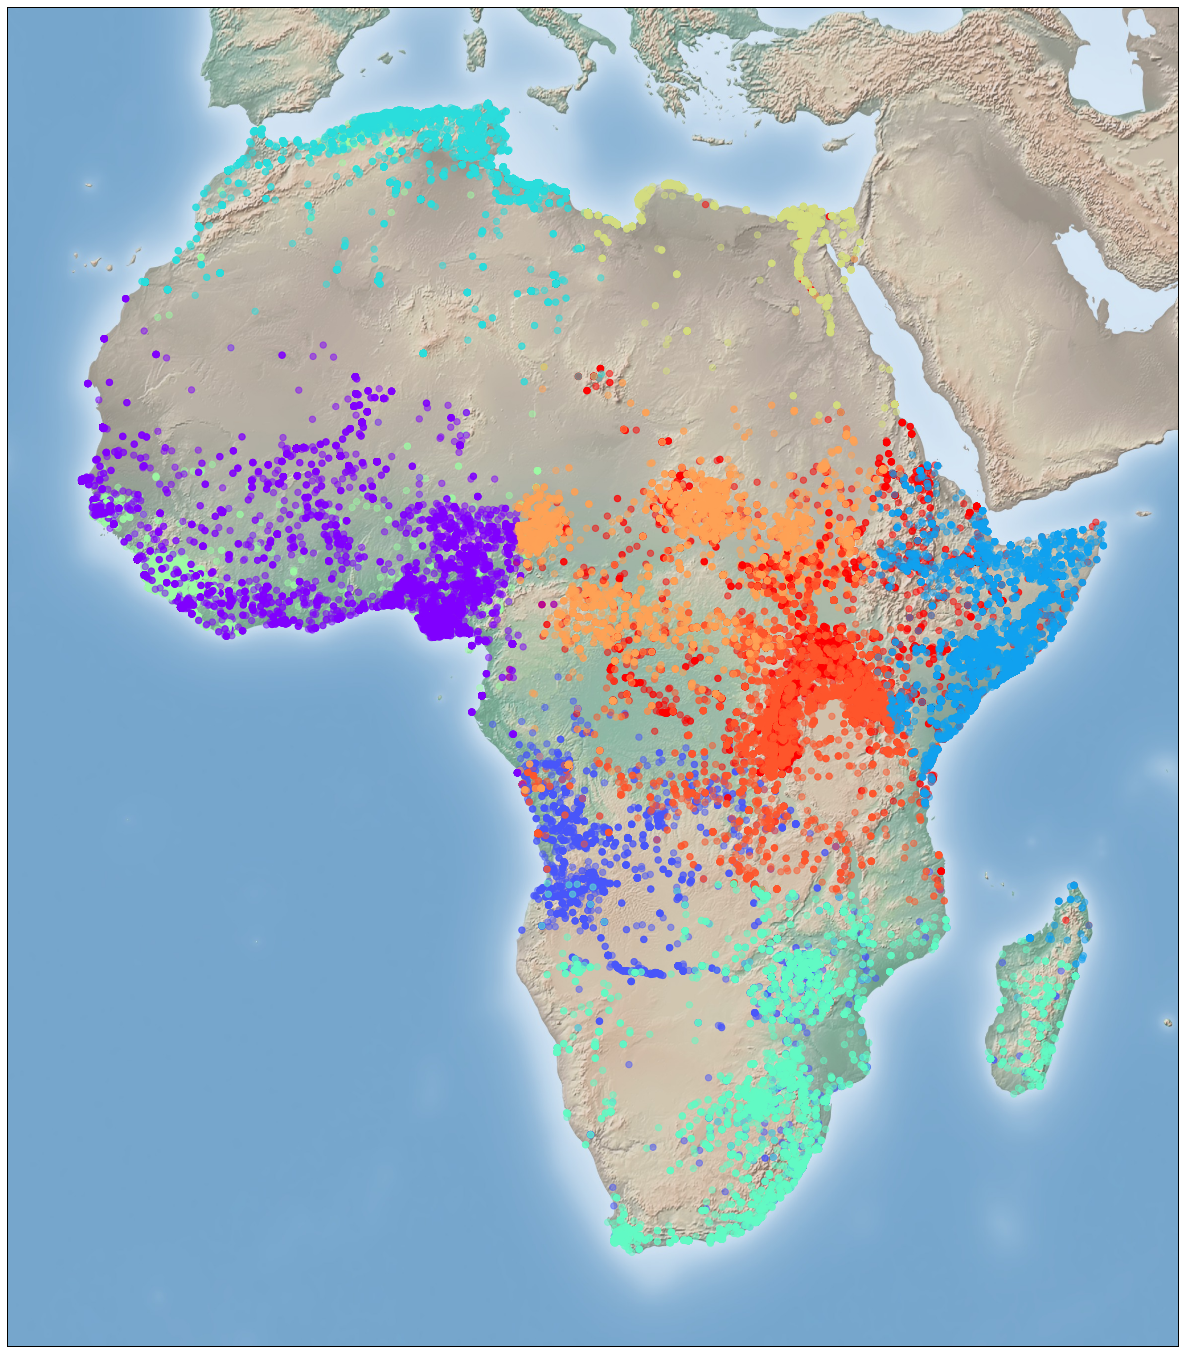

In [198]:
m = Basemap(projection='merc',
            llcrnrlat=lat_min - 5,
            urcrnrlat=lat_max + 5,
            llcrnrlon=lon_min-5,
            urcrnrlon=lon_max+5,
            lat_ts=20,resolution='c')
m.shadedrelief()
x, y = m(lon.collect(), lat.collect())
c = matplotlib.cm.rainbow(np.linspace(0, 1, nClusters))[labels.collect()]
m.scatter(x, y, color=c, alpha=.5, s=40)
savefig('africa10.png')